### SPH-Interpolators
`sph-lib` allows to interpolate fields from tracers (particles) to arbitrary coordinates. The used interpolation kernel is a quintic spline.\
The central class is the `sph_interpolator` class that is initialized as follows
- `particle_positions`:   particle positions of shape (N, dim)
- `particle_masses`:  particle masses
- `boxsize`:    boxsize of periodic box; **IF** specified assume periodicity, **ELSE** assumes data is non-periodic
- `number_of_nn`: number of nearest neighbors to use when interpolating

The central routine is the `query_field_at_positions` function, that takes as input the field values `particle_field` and the query coordinates.\
It returns the interpolated field values at those positions.

In [1]:
import numpy as np
import pynbody as pn
import matplotlib.pyplot as plt

from sph_lib.interpolation import sph_interpolator
from sph_lib.utils import create_grid_2d, create_grid_3d

plt.style.use('~/code/custom_mpl/stylesheets/mnras')
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Load particle data and setup grid coordinates

In [18]:
ds = pn.load('/shares/feldmann.ics.mnf.uzh/data/FIREbox/production_runs/FB15N128/snapshot_344.hdf5')
boxsize = 15000
NN = 64

pos    = ds.gas['pos']
masses = ds.gas['mass']
temp   = ds.gas['temp']
vel    = ds.gas['vel'][:, 0]

nx = 200
grid_2d = create_grid_2d(nx, nx, boxsize)
grid_3d = create_grid_3d(nx, nx, nx, boxsize)

### Interpolation: 2d version
Let's interpolate the surface density $\sigma$, temperature and velocity fields onto arbitrary coordinates (note here we use equidistant grids for simplicity).

In [19]:
# lets use the particles in a slab of 10% boxsize width to interpolate the values at grid coordinates
mask = np.logical_and(pos[:, -1] > 13500,
                      pos[:, -1] < 15000)
pos_masked    = pos[mask]
masses_masked = masses[mask]
temp_masked   = temp[mask]
vel_masked    = vel[mask]

Interpolator = sph_interpolator(pos_masked[:, :2],
                                masses_masked, 
                                boxsize, 
                                NN)

Init: 	 computing 2d hsm and ρ


In [20]:
# Mass deposit does not make sense -> interpolate density instead
σ = Interpolator.rho
fields_to_interpolate = [σ, temp_masked, vel_masked]

grids   = Interpolator.query_field_at_positions(fields_to_interpolate, grid_2d)

σ_grid  = grids[0].reshape((nx, nx))
t_grid  = grids[1].reshape((nx, nx))
v_grid  = grids[2].reshape((nx, nx))

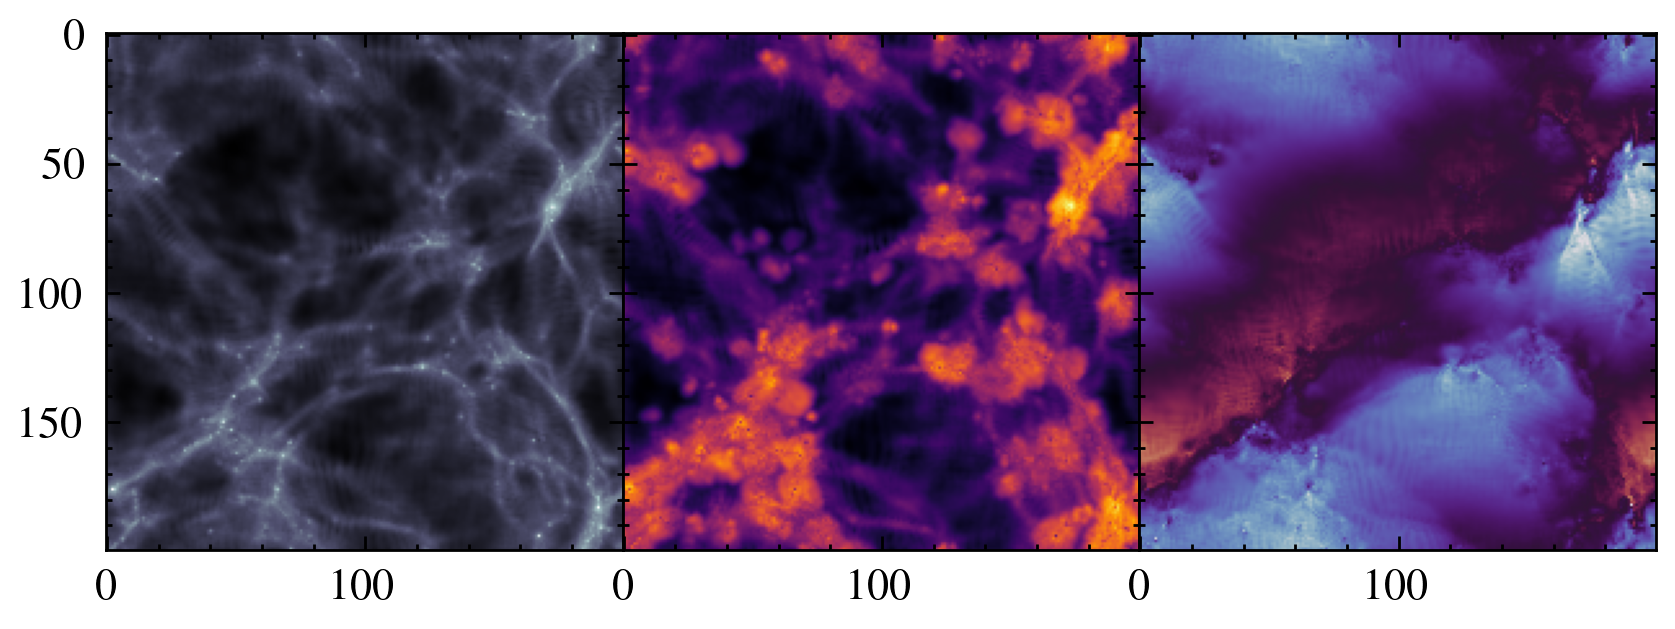

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(5, 2), sharex=True, sharey=True)
ax[0].imshow(np.log10(σ_grid), cmap='bone')
ax[1].imshow(np.log10(t_grid), cmap='inferno')
ax[2].imshow(v_grid, cmap='twilight')

plt.savefig('plots/interpolation_2d.png', transparent=True, dpi=300)
plt.show()

In [22]:
total_mass_sim = masses_masked.sum()
total_mass_grid = σ_grid.mean() * boxsize**2
print('Difference in sampled mass:', abs(100 * (1-total_mass_sim / total_mass_grid)), '%')

Difference in sampled mass: 0.4170632107887817 %


### Interpolation: 3d grid
The difference between 2d and 3d interpolation is the computation of the smoothing length of particles,\
which is either computing the 2d "surface" smoothing circle or 3d smoothing sphere.

In [7]:
Interpolator = sph_interpolator(pos, masses, boxsize, NN)

ρ = Interpolator.rho
fields_to_interpolate = [ρ, temp, vel]

grids  = Interpolator.query_field_at_positions(fields_to_interpolate, grid_3d)

ρ_grid  = grids[0].reshape((nx, nx, nx))
t_grid  = grids[1].reshape((nx, nx, nx))
v_grid  = grids[2].reshape((nx, nx, nx))


Init: 	 computing 3d hsm and ρ


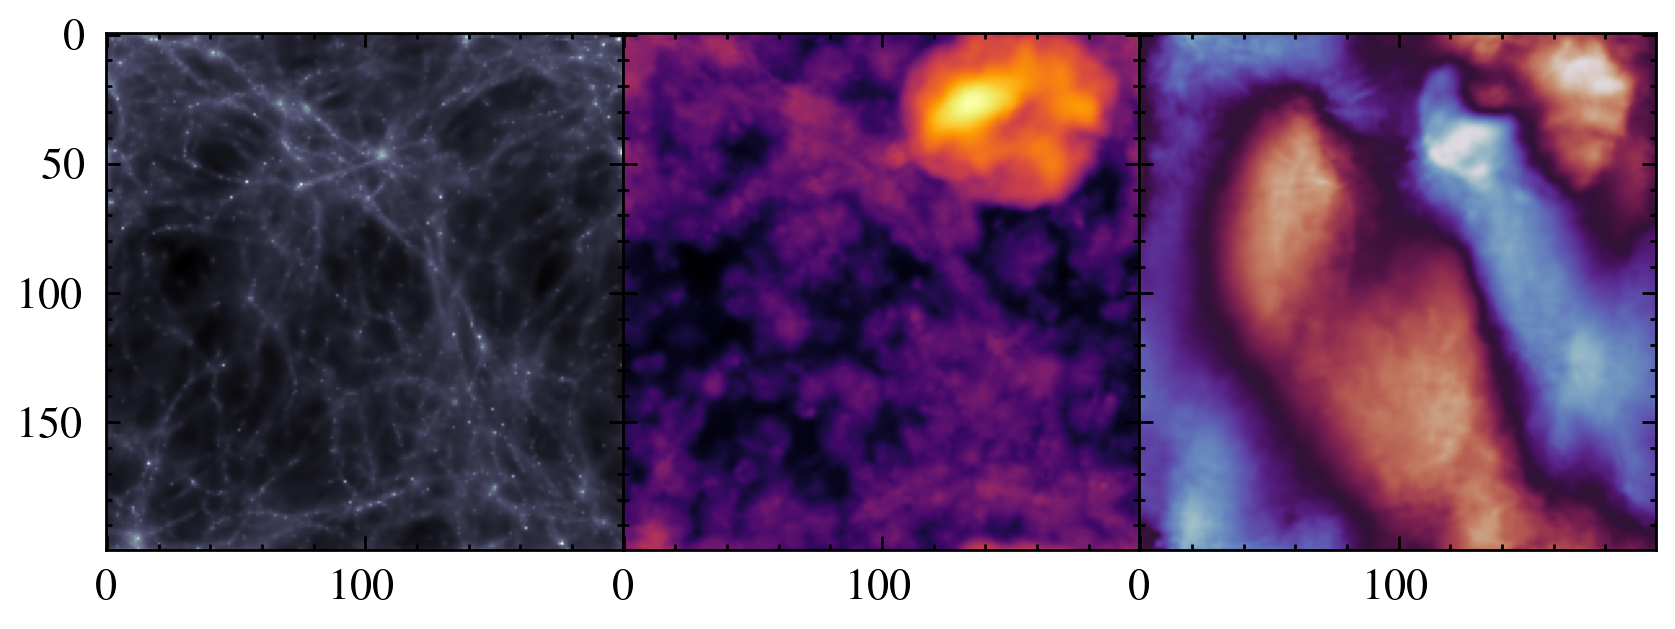

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(5, 2), sharex=True, sharey=True)
ax[0].imshow(np.log10(ρ_grid.sum(axis=-1)), cmap='bone')
ax[1].imshow(np.log10(t_grid.sum(axis=-1)), cmap='inferno')
ax[2].imshow(v_grid.sum(axis=-1), cmap='twilight')

plt.savefig('plots/interpolation_3d.png', transparent=True, dpi=300)
plt.show()

In [9]:
total_mass_sim = masses.sum()
total_mass_grid = ρ_grid.mean() * boxsize**3

print('Difference in sampled mass:', abs(100 * (1-total_mass_sim / total_mass_grid)), '%')

Difference in sampled mass: 3.5469151159794765 %


### Interpolation with different kernels (2D case)

In [13]:
kernels = ['gaussian', 'super_gaussian', 'cubic', 'quintic', 'wendland_c2', 'wendland_c4', 'wendland_c6']
fields  = [] 
for kernel in kernels:
    Interpolator = sph_interpolator(pos_masked[:, :2],
                                    masses_masked, 
                                    boxsize, 
                                    NN,
                                    kernel=kernel)

    # Mass deposit does not make sense -> interpolate density instead
    σ = Interpolator.rho
    fields_to_interpolate = [σ]
    grids   = Interpolator.query_field_at_positions(fields_to_interpolate, grid_2d)
    fields.append(grids[0].reshape((nx, nx)))

Init: 	 computing 2d hsm and ρ
Init: 	 computing 2d hsm and ρ
Init: 	 computing 2d hsm and ρ
Init: 	 computing 2d hsm and ρ
Init: 	 computing 2d hsm and ρ
Init: 	 computing 2d hsm and ρ
Init: 	 computing 2d hsm and ρ


In [14]:
for kernel, field in zip(kernels, fields):
    print(f'Total mass using {kernel}: \t {field.sum()}' )

Total mass using gaussian: 	 0.0918429118322788
Total mass using super_gaussian: 	 0.0969394879732643
Total mass using cubic: 	 0.09140989850881708
Total mass using quintic: 	 0.09256742511193938
Total mass using wendland_c2: 	 0.09264267849914229
Total mass using wendland_c4: 	 0.09230887483949324
Total mass using wendland_c6: 	 0.11428717837270592


In [15]:
fov = np.s_[:, :fields[0].shape[0] // 2]
fields_fov = [f[fov] for f in fields]

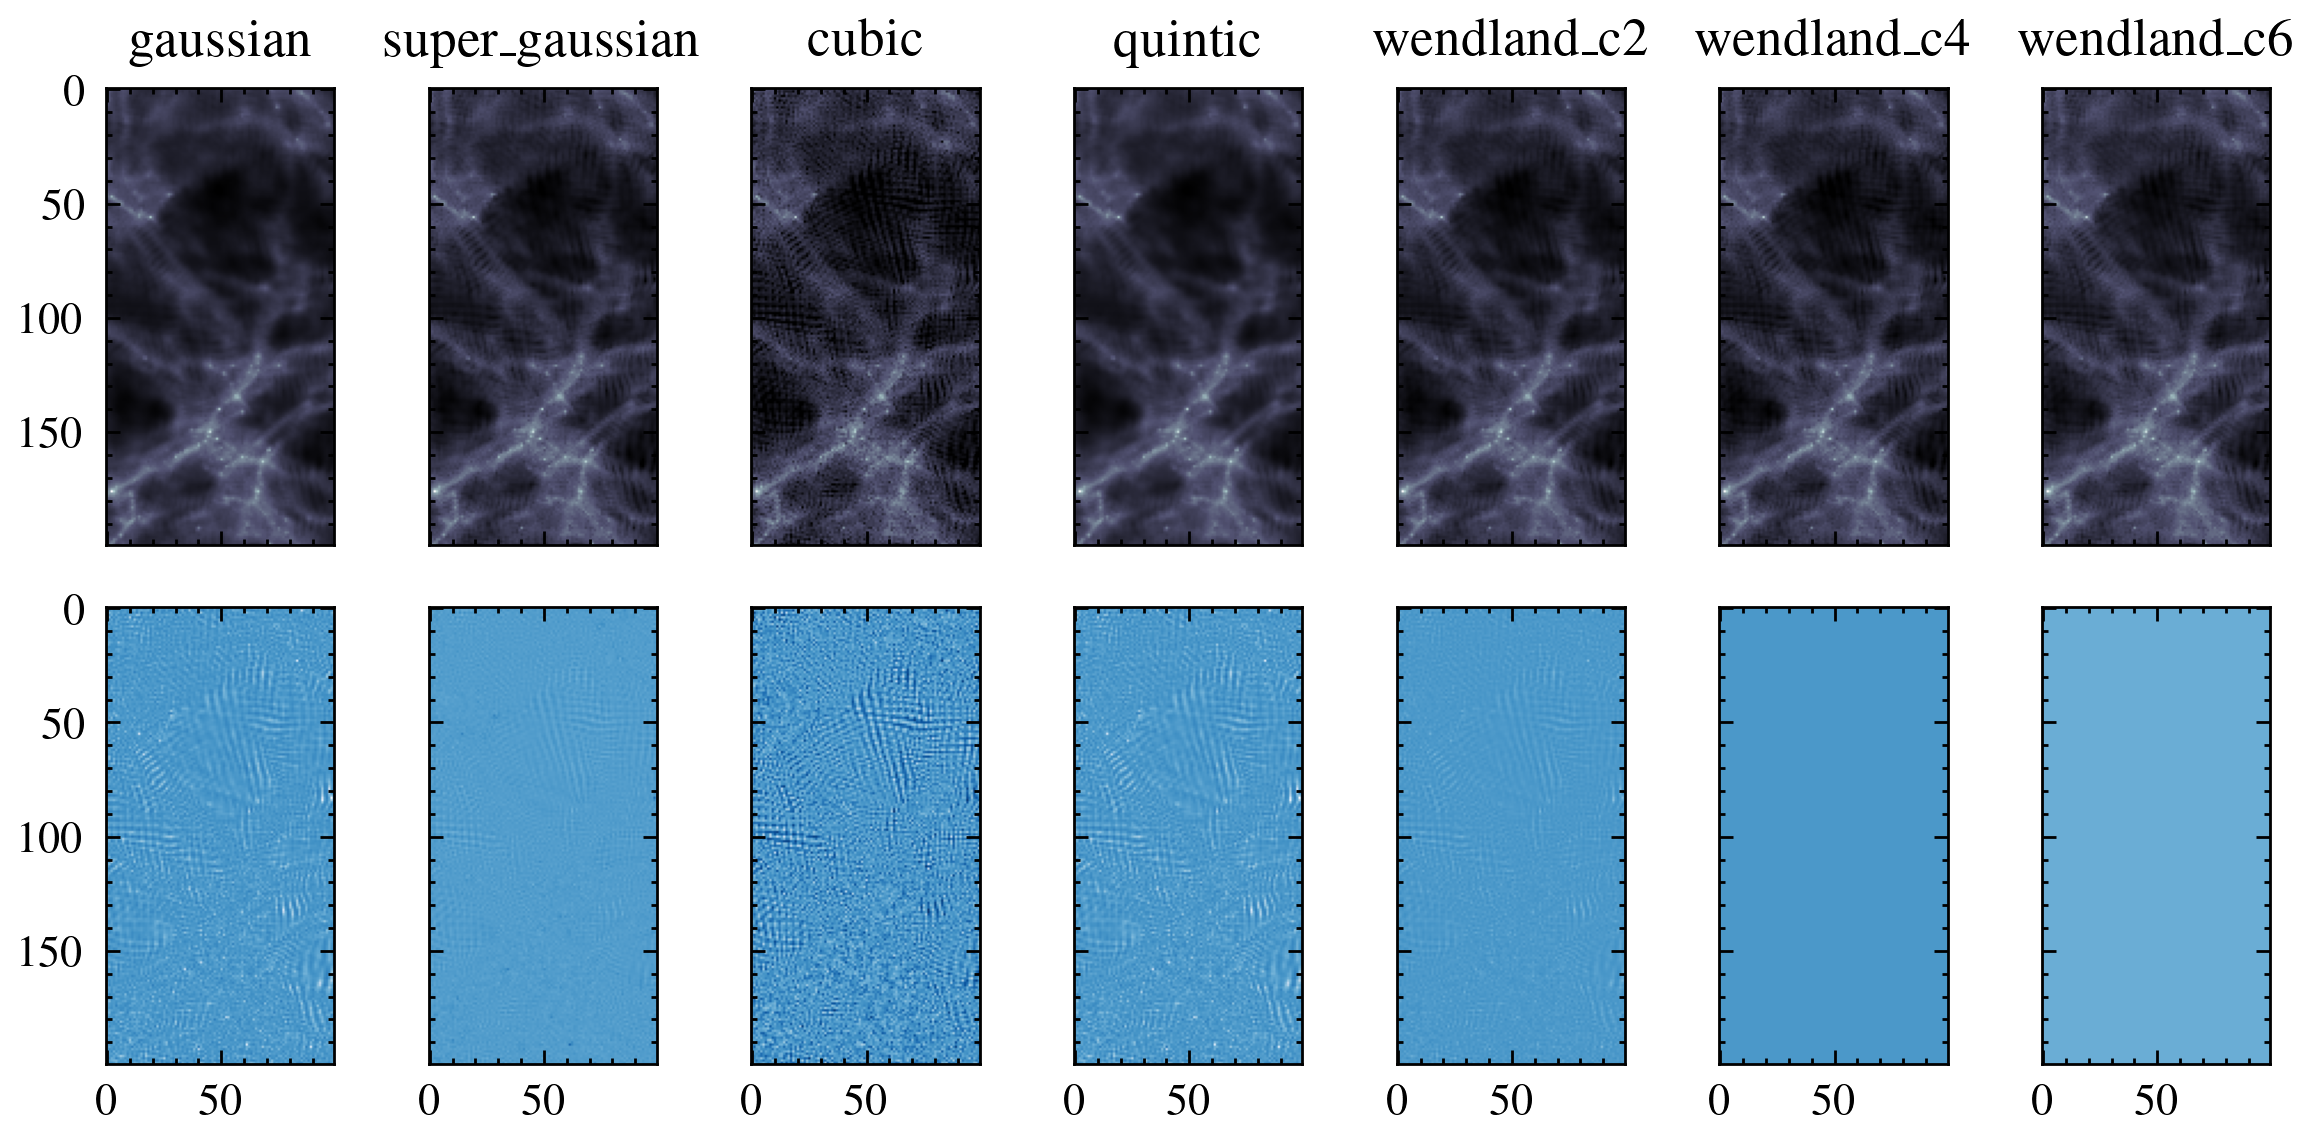

In [17]:
fig, ax = plt.subplots(2, len(kernels), figsize=(6, 3), sharex=True, sharey=True)

for i in range(len(kernels)):
    ax[0, i].imshow(np.log10(fields_fov[i]), 
                    cmap='bone',
                    vmin=np.log10(fields_fov[0]).min(),
                    vmax=np.log10(fields_fov[0]).max())
    
    ax[1, i].imshow(1 - fields_fov[i] / fields_fov[-1], cmap='Blues',
                    vmin=-1, vmax=1)
    ax[0, i].set(title=kernels[i])

plt.tight_layout()
plt.savefig('plots/interpolation_2d_kernel_comparison.png', transparent=True, dpi=300)
plt.show()